In [11]:
import csv
import numpy as np
import matplotlib.pyplot as plt


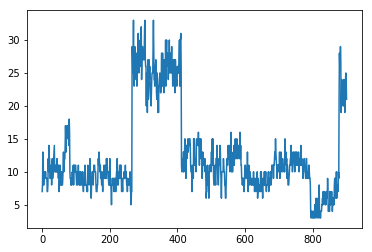

In [29]:
num_detection = []
detection_score = []

with open('/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_arat30-60.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    num_detection = [int(row['num_detections']) for row in reader]
    
    #for row in reader:
    #    tmp_num = int(row['num_detections'])
    #    num_detection.append(tmp_num)
        
        
        #tmp_score = []
        #for score in row['detection_scores']:
        #    print(score)
            #tmp_score.append(float(score))
        #detection_score.append(tmp_score)
            
        
        #print(row['num_detections'])
        
        
#num_detections detection_boxes detection_scores detection_classes

plt.plot(np.arange(len(num_detection)), num_detection)
plt.show()

In [116]:
boxes_output = []
box_per_frame = []
mean_box_size_per_frame = []
human_box_per_frame = []

with open('/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_arat30-60.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    # Loop over the rows in the file
    for row in reader :
        # Get the number of detection for a given row
        num_detect = int(row['num_detections'])
        box_per_frame.append(num_detect)
        #print(num_detect)
        
        # Get the detection scores of those detections
        detect_score = row['detection_scores'][1:-1].split()[:num_detect]
        # Convert the string to a float
        detect_score = [float(item) for item in detect_score]
        #print(detect_score)
        
        # Get the classes of those detections
        classes = row['detection_classes'][1:-1].split()[:num_detect]
        # Convert the string to int
        classes = [int(item) for item in classes]
        #print(classes)
        
        # Get the bounding boxes positions
        xmin = []
        ymin = []
        xmax = []
        ymax = []
        # save the box mean size
        mean_size = 0

        bounding_box = row['detection_boxes'][2:-2]
        tmp_values_allboxes = bounding_box.split(']\n [')
        for val in tmp_values_allboxes[:num_detect]:
            ymin.append(float(val.split()[0]))
            xmin.append(float(val.split()[1]))
            ymax.append(float(val.split()[2]))
            xmax.append(float(val.split()[3]))
            mean_size += (float(val.split()[2])-float(val.split()[0]))*(float(val.split()[3])-float(val.split()[1]))

        #print(bounding_box.split(']\n [')[0].split())

        # Normalize the mean size
        mean_size = mean_size / num_detect
        mean_box_size_per_frame.append(mean_size)
        boxes_output.append([detect_score, classes, ymin, xmin, ymax, xmax])
        
#print(boxes_output)

In [117]:
len(boxes_output[10][0])

10

In [114]:
# Method that takes the csv file as input and return the informations about the bounding boxes per frame
def get_boxes_information(csvfilename) :
    # Define the output
    boxes_output = []
    box_per_frame = []

    # Open the file
    with open() as csvfile:
        reader = csv.DictReader(csvfile)
        # Loop over the rows in the file
        for row in reader :
            # Get the number of detection for a given row
            num_detect = int(row['num_detections'])
            box_per_frame.append(num_detect)
            #print(num_detect)

            # Get the detection scores of those detections
            detect_score = row['detection_scores'][1:-1].split()[:num_detect]
            # Convert the string to a float
            detect_score = [float(item) for item in detect_score]
            #print(detect_score)

            # Get the classes of those detections
            classes = row['detection_classes'][1:-1].split()[:num_detect]
            # Convert the string to int
            classes = [int(item) for item in classes]
            #print(classes)

            # Get the bounding boxes positions
            xmin = []
            ymin = []
            xmax = []
            ymax = []
            bounding_box = row['detection_boxes'][2:-2]
            tmp_values_allboxes = bounding_box.split(']\n [')
            for val in tmp_values_allboxes[:num_detect]:
                ymin.append(float(val.split()[0]))
                xmin.append(float(val.split()[1]))
                ymax.append(float(val.split()[2]))
                xmax.append(float(val.split()[3]))


            # Normalize the mean size
            mean_size = mean_size / num_detect
            mean_box_size_per_frame.append(mean_size)
            boxes_output.append([detect_score, classes, ymin, xmin, ymax, xmax])

    
    return boxes_output, box_per_frame
    

In [121]:
# Methode that returns the number of human boxes per frame for a given threshold over detection confidence
def get_human_boxes_per_frame(boxes_info, threshold = 0.5) :
    human_per_frame = []
    # loop over all frames
    for frame in boxes_info :
        # define a mean to zero
        count = 0
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            # check the score is greather than the threshold and the class is human
            if frame[0][i] > threshold and frame[1][i]==1:
                count = count+1
        human_per_frame.append(count)        
            
    return human_per_frame


# Methode that returns the mean human boxes size per frame for a given threshold over detection confidence
def get_mean_human_boxes_size_per_frame(boxes_info, threshold = 0.5) :
    mean_box_size = []
    # loop over all frames
    for frame in boxes_info :
        # define a mean to zero
        mean = 0
        count = 0
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            # check the score is greather than the threshold and the class is human
            if frame[0][i] > threshold and frame[1][i]==1:
                mean = (frame[4][i]-frame[2][i])*(frame[5][i]-frame[3][i])
                count += 1
        mean_box_size.append(mean/count)        
            
    return mean_box_size

def get_human_boxes_size_hist(boxes_info, threshold = 0.5):
    human_box_size = []
    # loop over all frames
    for frame in boxes_info :
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            # check the score is greather than the threshold and the class is human
            if frame[0][i] > threshold and frame[1][i]==1:
                human_box_size.append((frame[4][i]-frame[2][i])*(frame[5][i]-frame[3][i]))
            
    return human_box_size
        

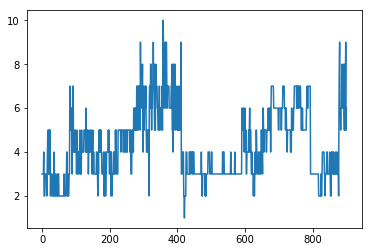

In [112]:
humans_per_frame = get_human_boxes_per_frame(boxes_output, threshold = 0.8)
plt.plot(np.arange(len(humans_per_frame)), humans_per_frame)
plt.show()

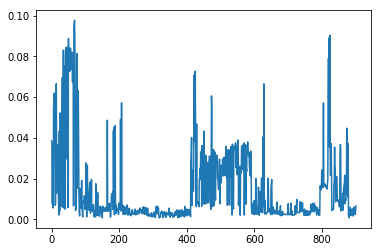

In [120]:
mean_human_size = get_mean_human_boxes_size_per_frame(boxes_output, threshold = 0.8)
plt.plot(np.arange(len(mean_human_size)), mean_human_size)
plt.show()

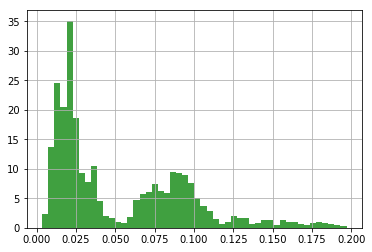

In [124]:
human_box_hist = get_human_boxes_size_hist(boxes_output, threshold = 0.8)
# the histogram of the data
n, bins, patches = plt.hist(human_box_hist, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#plt.xlabel('Smarts')
#plt.ylabel('Probability')
#plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

In [26]:
with open('/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_arat30-60.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    num_detect = [int(row['num_detections']) for row in reader]

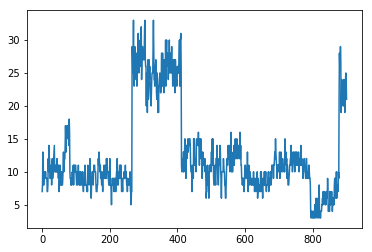

In [101]:
plt.plot(np.arange(len(box_per_frame)), box_per_frame)
plt.show()

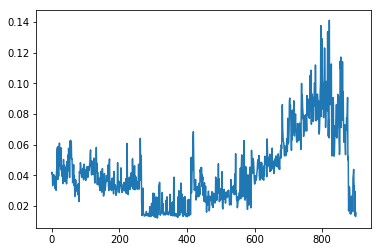

In [103]:
plt.plot(np.arange(len(box_per_frame)), mean_box_size_per_frame)
plt.show()